<a href="https://colab.research.google.com/github/Alexandre77777/neural_networks/blob/main/6.%20%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%966_%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B0%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D0%BE%D0%B2_%D0%B4%D0%BB%D1%8F_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BF%D1%80%D0%B8%D0%BA%D0%BB%D0%B0%D0%B4%D0%BD%D1%8B%D1%85_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

### - **N.B.: Во всех заданиях, графический интерфейс для взаимодействия с обученной моделью, реализуется с помощью Gradio!**

### - **Для каждого задания в графическом интерфейсе должно быть встроено минимум 3 примера (sample)**

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета.

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [ ]:
from keras.datasets import fashion_mnist
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization, Activation
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import random
import pickle
import cv2
import os
from google.colab.patches import cv2_imshow
from google.colab import files
from io import BytesIO
from PIL import Image
from urllib.request import urlopen

In [ ]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 128, 128, 3))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2, n):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    indices = np.random.randint(len(array1), size=n)
    images1 = np.asarray(array1)[indices, :]
    images2 = np.asarray(array2)[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
images = []
wb_images = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/five_animals_dataset")))
n = len(imagePaths)
for i in range(n):
	if i %100 == 0:
		print(i)
	image = cv2.imread(imagePaths[i]) # загружаем изображение
	try:
		image = cv2.resize(image, (128, 128))
		images.append(image) # добавляем в список
		gray1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		gray3 = np.zeros_like(image)
		gray3[:,:,0] = gray1
		gray3[:,:,1] = gray1
		gray3[:,:,2] = gray1
		wb_images.append(gray3)
	except Exception as e:
		print(e)
		print('фото не обработалось',imagePaths[i])
print(i, 'фотографий')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
2999 фотографий


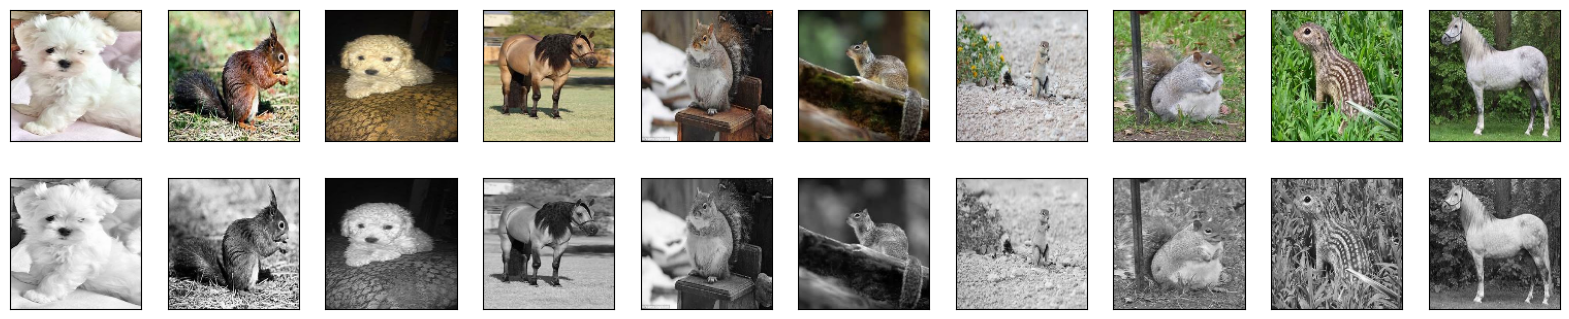

In [ ]:
display(images, wb_images,  10)

In [ ]:
input = layers.Input(shape=(128, 128, 3))

# Encoder
x = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)


from keras import optimizers

optimizer = optimizers.Adam(0.0001)
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse', 'accuracy'])
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 128)     147584    
 Transpose)                                                      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 3)       3459      
                                                                 
Total params: 154627 (604.01 KB)
Trainable params: 154627 (

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss',
                               start_from_epoch=5,
                               mode="min",
                               patience=5) # Остановка обучения, если
                                             # валидационная точность не
                                             # улучшается в течение 5 эпох
checkpoint = ModelCheckpoint(filepath="best_model_colors.h5",
                             monitor="val_loss",
                             save_best_only=True,
                             verbose=0) # Сохранение модели
                                         # только при улучшении
                                         # валидационной точности

In [ ]:
from sklearn.model_selection import train_test_split
n_images = preprocess(np.asarray(images))
n_wb_images = preprocess(np.asarray(wb_images))

X_train, X_test, y_train, y_test = train_test_split(n_wb_images, n_images, test_size=0.2, random_state=0)

autoencoder.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=50,
    shuffle=True,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
48/48 [==============================] - 11s 195ms/step - loss: 0.0686 - mse: 0.0686 - accuracy: 0.4903 - val_loss: 0.0650 - val_mse: 0.0650 - val_accuracy: 0.4970
Epoch 2/50
48/48 [==============================] - 9s 190ms/step - loss: 0.0584 - mse: 0.0584 - accuracy: 0.4935 - val_loss: 0.0501 - val_mse: 0.0501 - val_accuracy: 0.4976
Epoch 3/50
48/48 [==============================] - 9s 192ms/step - loss: 0.0375 - mse: 0.0375 - accuracy: 0.4929 - val_loss: 0.0264 - val_mse: 0.0264 - val_accuracy: 0.4959
Epoch 4/50
48/48 [==============================] - 9s 179ms/step - loss: 0.0199 - mse: 0.0199 - accuracy: 0.4888 - val_loss: 0.0169 - val_mse: 0.0169 - val_accuracy: 0.4881
Epoch 5/50
48/48 [==============================] - 9s 192ms/step - loss: 0.0144 - mse: 0.0144 - accuracy: 0.4873 - val_loss: 0.0139 - val_mse: 0.0139 - val_accuracy: 0.4944
Epoch 6/50
48/48 [==============================] - 9s 190ms/step - loss: 0.0122 - mse: 0.0122 - accuracy: 0.4866 - val_loss: 0.0

19/19 [==============================] - 1s 36ms/step


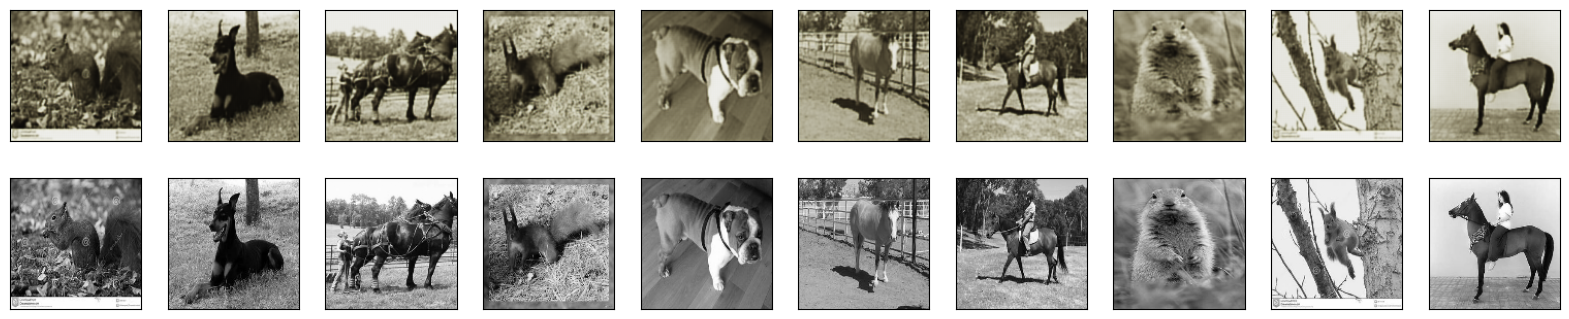

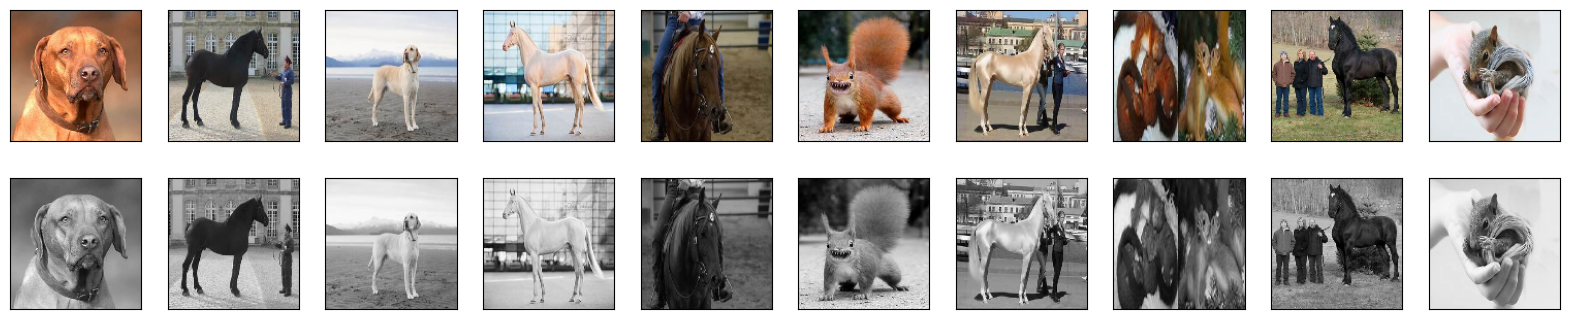

In [ ]:
predictions = autoencoder.predict(X_test)
display(predictions, X_test, 10)
display(images, wb_images, 10)

In [ ]:
autoencoder.save('/content/data/MyDrive/autoencoder_colors.h5')

In [ ]:
from keras.models import load_model

model = load_model("/content/data/MyDrive/autoencoder_colors.h5")

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np

# загрузка данных
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# выбор изображений одного типа
class_idx = 8  # индекс выбранного класса
train_images_class = train_images[train_labels[:,0]==class_idx]
test_images_class = test_images[test_labels[:,0]==class_idx]

169001437/169001437 [==============================] - 5s 0us/step


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from skimage.color import rgb2gray


def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(rgb2gray(image1).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rgb2gray(image2).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

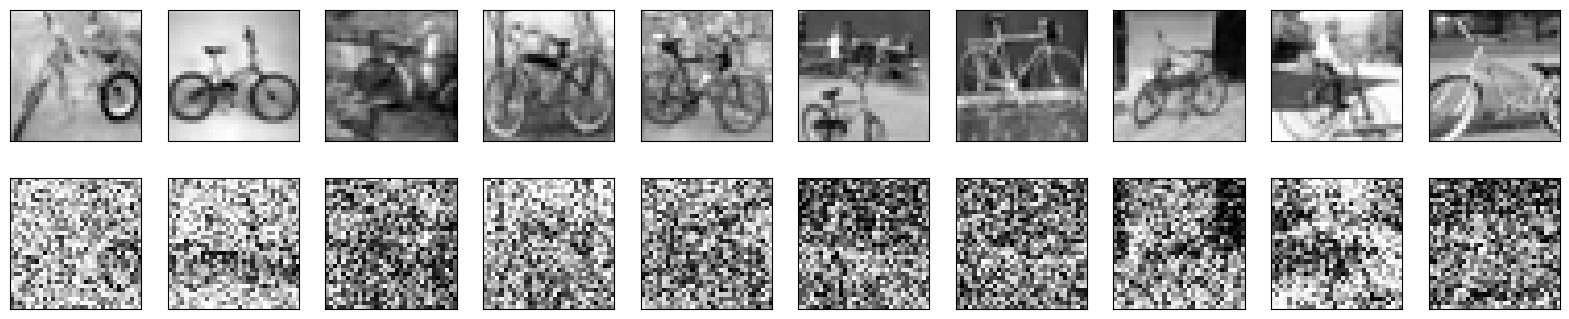

In [ ]:
# Нормализация и изменение формы данных
train_data = preprocess(train_images_class)
test_data = preprocess(test_images_class)

# Создание копии данных с добавленным шумом
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Отображение данных выборки и его версии с добавленным шумом
display(train_data, noisy_train_data)

In [ ]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 32)        9248

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=1000,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, noisy_test_data),
)

Epoch 1/1000
4/4 [==============================] - 5s 324ms/step - loss: 0.6932 - accuracy: 0.2532 - val_loss: 0.6924 - val_accuracy: 0.3358
Epoch 2/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.6916 - accuracy: 0.2984 - val_loss: 0.6908 - val_accuracy: 0.3386
Epoch 3/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.6886 - accuracy: 0.3051 - val_loss: 0.6877 - val_accuracy: 0.3332
Epoch 4/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.6838 - accuracy: 0.3160 - val_loss: 0.6864 - val_accuracy: 0.3383
Epoch 5/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.6764 - accuracy: 0.3804 - val_loss: 0.6905 - val_accuracy: 0.3437
Epoch 6/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.6647 - accuracy: 0.4205 - val_loss: 0.7175 - val_accuracy: 0.3439
Epoch 7/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.6515 - accuracy: 0.4427 - val_loss: 0.7980 - val_accuracy: 0.3421
Epoch 8/1000

4/4 [==============================] - 0s 41ms/step


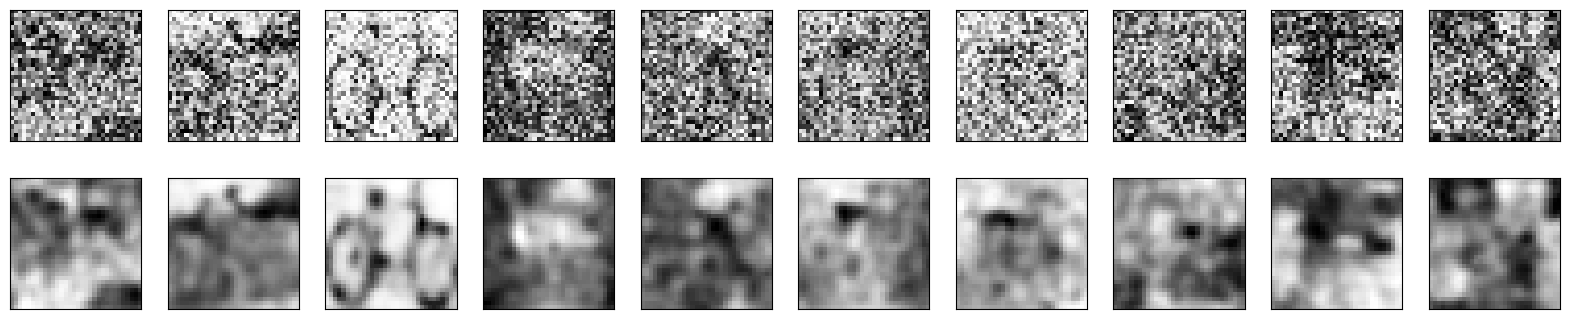

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoder_best_noise.h5')

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку.

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 64, 64, 3))
    return array

In [ ]:
images128 = []
images64 = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/five_animals_dataset")))

n = len(imagePaths)
print(n)
for i in range(n):
	if i % 500 == 0:
		print(i)
	image = cv2.imread(imagePaths[i])
	try:
		images128.append(cv2.resize(image, (128, 128)))
		images64.append(cv2.resize(image, (64, 64)))
	except Exception as e:
		print(e)
		print('фото не обработалось',imagePaths[i])
print(i, 'фотографий')

3000
0
500
1000
1500
2000
2500
2999 фотографий


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Activation
from keras.layers import PReLU

model = Sequential()

model.add(Conv2D(128, (5, 5), padding='same', kernel_initializer='he_normal',  input_shape=(128, 128, 3)))
model.add(PReLU())

model.add(Conv2D(64, (1, 1), padding='same', kernel_initializer='he_normal'))
model.add(PReLU())

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(PReLU())

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(PReLU())

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(PReLU())

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(PReLU())

model.add(Conv2D(128, (1, 1), padding='same', kernel_initializer='he_normal'))
model.add(PReLU())

model.add(Conv2DTranspose(1, (9, 9), strides=(3, 3), padding='same'))


model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 32)        9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 32)      9248      
 Transpose)                                                      
                                                           

In [ ]:
from keras import optimizers

optimizer = optimizers.Adam(0.00001)
# Autoencoder

model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse', 'accuracy'])

In [ ]:
def preprocess(array, n):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), n, n, 3))
    return array

In [ ]:
from sklearn.model_selection import train_test_split

print(np.asarray(images64).shape, np.asarray(images128).shape)
images64 = preprocess(np.asarray(images64), 64)
images128 = preprocess(np.asarray(images128), 128)

X_train, X_test, y_train, y_test = train_test_split(images64, images128, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3000, 64, 64, 3) (3000, 128, 128, 3)
(2400, 64, 64, 3) (600, 64, 64, 3) (2400, 128, 128, 3) (600, 128, 128, 3)


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_accuracy',
                               start_from_epoch=5,
                               mode="max",
                               patience=5) # Остановка обучения, если
                                             # валидационная точность не
                                             # улучшается в течение 5 эпох
checkpoint = ModelCheckpoint(filepath="best_model_upsampling.h5",
                             monitor="val_loss",
                             save_best_only=True,
                             verbose=0) # Сохранение модели
                                         # только при улучшении
                                         # валидационной точности

In [ ]:
model.fit(
    x=X_train,
    y=y_train,
    epochs=250,
    batch_size=50,
    shuffle=True,
    validation_data=(X_test, y_test),

    callbacks=[early_stopping, checkpoint]
)

Epoch 1/250
48/48 [==============================] - 4s 60ms/step - loss: 0.0736 - mse: 0.0736 - accuracy: 0.2678 - val_loss: 0.0734 - val_mse: 0.0734 - val_accuracy: 0.2713
Epoch 2/250
48/48 [==============================] - 2s 46ms/step - loss: 0.0734 - mse: 0.0734 - accuracy: 0.2815 - val_loss: 0.0732 - val_mse: 0.0732 - val_accuracy: 0.2855
Epoch 3/250
48/48 [==============================] - 2s 49ms/step - loss: 0.0732 - mse: 0.0732 - accuracy: 0.2923 - val_loss: 0.0730 - val_mse: 0.0730 - val_accuracy: 0.2994
Epoch 4/250
48/48 [==============================] - 2s 50ms/step - loss: 0.0729 - mse: 0.0729 - accuracy: 0.3093 - val_loss: 0.0728 - val_mse: 0.0728 - val_accuracy: 0.3206
Epoch 5/250
48/48 [==============================] - 2s 49ms/step - loss: 0.0727 - mse: 0.0727 - accuracy: 0.3301 - val_loss: 0.0725 - val_mse: 0.0725 - val_accuracy: 0.3423
Epoch 6/250
48/48 [==============================] - 2s 49ms/step - loss: 0.0723 - mse: 0.0723 - accuracy: 0.3476 - val_loss: 0.07

75/75 [==============================] - 1s 11ms/step
(64, 64, 3) (128, 128, 3)


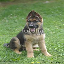

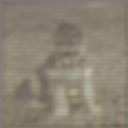

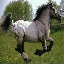

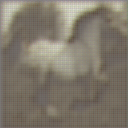

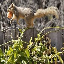

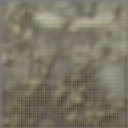

In [ ]:
predictions = model.predict(X_train)
print(X_train[0].shape,predictions[0].shape)
for i in range(3):
  cv2_imshow(X_train[i]*255.0)
  cv2_imshow(predictions[i]*255.0)

In [ ]:
autoencoder.save('/content/drive/MyDrive/autoencoder_upsampling.h5')